# Setup Variables

In [1]:
REPO_PATH = '/home/ah19/runtime-monitoring'
DATASET = 'Cifar10'
PREFIX = 'TEMP'
FILENAME_POSTFIX = f"{DATASET}_{PREFIX}"
SEED = 42

GPU_NAME = 'cuda:0'

model_config = {
    'batch_size': 64,
    'lr': 0.001,
    'epochs': 25,
    "patience": 5,
    "L2": 0.00,
    "L1": 0.00,
}

# Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import torch
from torch.backends import cudnn
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

In [3]:
import sys
sys.path.append(REPO_PATH + '/utilities')
sys.path.append(f'{REPO_PATH}/{DATASET}/trainingModels')

In [4]:
from utils import *
from plotFunctions import *
from pathManager import fetchPaths
# from Cifar10_CNN import Cifar10_CNN

# model_ = Cifar10_CNN

# GPU Device & Seed

In [5]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [6]:
device = get_device(GPU_NAME)
torch.cuda.get_device_name(device)

'NVIDIA A100 80GB PCIe'

# Paths

In [7]:
base = Path(REPO_PATH)
paths = fetchPaths(base, DATASET)

path = paths[DATASET.lower()]
path_dataset = paths['dataset']
path_trainingModels = paths['trainingModels']
path_lastHiddenLayer = paths['lastHiddenLayer']
path_lastHiddenLayer_raw = paths['lastHiddenLayer_raw']
path_savedModels = paths['savedModels']

# save model and logs to dedicated directory
path_savedModels = path_savedModels / FILENAME_POSTFIX
path_savedModels.mkdir(exist_ok=True) # raise error if model name was used previously

path, path_savedModels

(PosixPath('/home/ah19/runtime-monitoring/Cifar10'),
 PosixPath('/home/ah19/runtime-monitoring/Cifar10/savedModels/Cifar10_TEMP'))

# Load / Split / DataLoader

In [8]:
feature_names = get_labels(DATASET)

# IMPORTANT Augmentation
tf_train = T.Compose([
#     T.RandomHorizontalFlip(),
#     T.RandomCrop(32, 4),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

tf_test = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])


train_data = get_dataset(DATASET, path_dataset, train=True, transform=tf_train)
test_data = get_dataset(DATASET, path_dataset, train=False, transform=tf_test)

trainloader = get_dataLoader(train_data, model_config['batch_size'], True)
testloader = get_dataLoader(test_data, model_config['batch_size'], False)

len(train_data), len(test_data)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

In [9]:
# import torchvision

# tf_train = T.Compose([
#     T.RandomHorizontalFlip(),
#     T.RandomCrop(32, 4),
#     T.ToTensor(),
#     T.Normalize((0.5071, 0.4865, 0.4409), (0.2009, 0.1984, 0.2023))
# ])

# tf_test = T.Compose([
#     T.ToTensor(),
#     T.Normalize((0.5071, 0.4865, 0.4409), (0.2009, 0.1984, 0.2023))
# ])

# train_data = torchvision.datasets.CIFAR100(path_dataset, train=True, transform=tf_train, download=True)
# test_data = torchvision.datasets.CIFAR100(path_dataset, train=False, transform=tf_test, download=True)

# trainloader = get_dataLoader(train_data, model_config['batch_size'], True)
# testloader = get_dataLoader(test_data, model_config['batch_size'], False)

In [10]:
# feature_names = {0: 'apple',1: 'aquarium_fish',2: 'baby',3: 'bear',4: 'beaver',5: 'bed',6: 'bee',
#     7: 'beetle',8: 'bicycle',9: 'bottle',10: 'bowl',11: 'boy',12: 'bridge',13: 'bus',14: 'butterfly',
#     15: 'camel',16: 'can',17: 'castle',18: 'caterpillar',19: 'cattle',20: 'chair',21: 'chimpanzee',
#     22: 'clock',23: 'cloud',24: 'cockroach',25: 'couch',26: 'cra',27: 'crocodile',28: 'cup',29: 'dinosaur',
#     30: 'dolphin',31: 'elephant',32: 'flatfish',33: 'forest',34: 'fox',35: 'girl',36: 'hamster',37: 'house',
#     38: 'kangaroo',
#     39: 'keyboard',
#     40: 'lamp',
#     41: 'lawn_mower',
#     42: 'leopard',
#     43: 'lion',
#     44: 'lizard',
#     45: 'lobster',
#     46: 'man',
#     47: 'maple_tree',
#     48: 'motorcycle',
#     49: 'mountain',
#     50: 'mouse',
#     51: 'mushroom',
#     52: 'oak_tree',
#     53: 'orange',
#     54: 'orchid',
#     55: 'otter',
#     56: 'palm_tree',
#     57: 'pear',
#     58: 'pickup_truck',
#     59: 'pine_tree',
#     60: 'plain',
#     61: 'plate',
#     62: 'poppy',
#     63: 'porcupine',
#     64: 'possum',
#     65: 'rabbit',
#     66: 'raccoon',
#     67: 'ray',
#     68: 'road',
#     69: 'rocket',
#     70: 'rose',
#     71: 'sea',
#     72: 'seal',
#     73: 'shark',
#     74: 'shrew',
#     75: 'skunk',
#     76: 'skyscraper',
#     77: 'snail',
#     78: 'snake',
#     79: 'spider',
#     80: 'squirrel',
#     81: 'streetcar',
#     82: 'sunflower',
#     83: 'sweet_pepper',
#     84: 'table',
#     85: 'tank',
#     86: 'telephone',
#     87: 'television',
#     88: 'tiger',
#     89: 'tractor',
#     90: 'train',
#     91: 'trout',
#     92: 'tulip',
#     93: 'turtle',
#     94: 'wardrobe',
#     95: 'whale',
#     96: 'willow_tree',
#     97: 'wolf',
#     98: 'woman',
#     99: 'worm',
# }

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


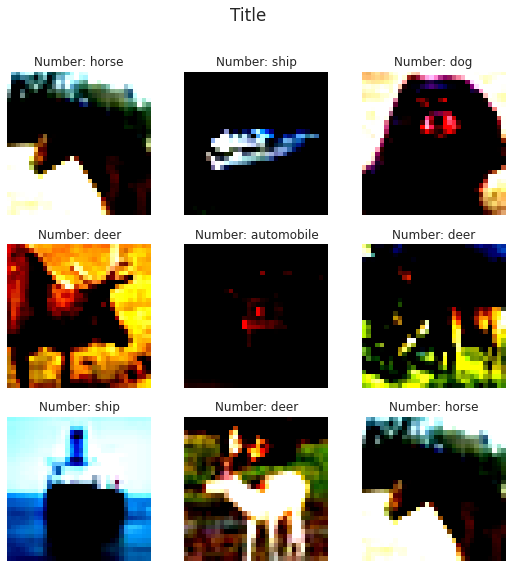

In [11]:
show_images_loader(trainloader, feature_names=feature_names)

# Model

In [12]:
class Cifar10_CNN(nn.Module):
    def __init__(self, img_dim=32, outneurons=100, last_hidden_neurons=200,  first_layer_norm=True,
        weight_init="kaiming_uniform", bias=True, dropout=0.0, batchnorm=True):

        super(Cifar10_CNN, self).__init__()

        self.channels = 3
        self.img_dim = img_dim
        self.in_features = 3 * img_dim * img_dim
        self.num_classes = outneurons
        self.last_hidden_neurons = last_hidden_neurons
        self.dropout_p = dropout
        self.batchnorm = batchnorm
        self.first_layer_norm = first_layer_norm

        # uniform(-1/sqrt(in_features), 1/sqrt(in_features))
        weights = {
            "normal": nn.init.normal_,
            "xavier": nn.init.xavier_normal_,
            "xavier_uniform": nn.init.xavier_uniform_,
            "kaiming": nn.init.kaiming_normal_,
            "kaiming_uniform": nn.init.kaiming_uniform_,
        }


        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        # scaling data
        self.scaleInputs = nn.BatchNorm2d(self.channels)
        self.dropout_l = nn.Dropout(self.dropout_p)
        self.pool = nn.MaxPool2d(2, 2)
        self.avgpool = nn.AvgPool2d(2, 2)

        self.layer1 = nn.Sequential(
            nn.Conv2d(self.channels, 96, 3, padding=3, bias=bias),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_p),
            
            nn.Conv2d(96, 96, 3, bias=bias),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_p),

            nn.Conv2d(96, 192, 3, bias=bias),
            nn.BatchNorm2d(192),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_p),
            nn.AvgPool2d(2, 2),

            nn.Conv2d(192, 192, 3, padding=3, bias=bias),
            nn.BatchNorm2d(192),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_p),

            nn.Conv2d(192, 64, 3, bias=bias),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_p),
            
            nn.Conv2d(64, 64, 3, bias=bias),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(self.dropout_p),
            nn.AvgPool2d(2, 2)
            )

        self.fc7 = nn.Linear(64 * 8 * 8, 1024, bias=bias)
        self.bn7 = nn.BatchNorm1d(1024)

        self.fc8 = nn.Linear(1024, 256, bias=bias)
        self.bn8 = nn.BatchNorm1d(256)

        self.fc9 = nn.Linear(256, last_hidden_neurons, bias=bias)
        self.bn9 = nn.BatchNorm1d(last_hidden_neurons)

        self.output = nn.Linear(last_hidden_neurons, outneurons, bias=bias)

        if weight_init is not None:
            self.__weight_init(weights[weight_init], bias)

    def forward(self, x):

        x = self._train(x)
        if self.batchnorm: x = self.bn9(x)
        x = self.relu(x)
        x = self.output(x)

        return x


    def _train(self, x):

        if self.first_layer_norm: x = self.scaleInputs(x)

        x = self.layer1(x)
        
        x = self.flatten(x)
        x = self.dropout_l(x)
        x = self.relu(self.bn7(self.fc7(x)))
        x = self.dropout_l(x)
        x = self.relu(self.bn8(self.fc8(x)))

        x = self.dropout_l(x)
        x = self.fc9(x)

        return x

    def output_last_layer(self, x):

        x = self._train(x)
        out = x.clone().detach()
        if self.batchnorm: x = self.bn9(x)
        x = self.relu(x)
        x = self.output(x)

        return out, x


    def _sum_weights(self):

        total_weights = 0
        for _, p in self.named_parameters():
            total_weights += p.sum()

        return total_weights.item()

    def _sum_abs_weights(self):

        total_weights = 0
        for _, p in self.named_parameters():
            total_weights += p.abs().sum()

        return total_weights.item()

    def _l1_regularization(self, alpha=1e-3):

        total_weights = 0
        for _, p in self.named_parameters():
            total_weights += p.abs().sum()

        return alpha * total_weights

    def _l2_regularization(self, lambd=1e-3):

        total_weights = 0
        for _, p in self.named_parameters():
            total_weights += p.pow(2).sum()

        return lambd * total_weights

    def _elastic_regularization(self, lambd=1e-3, alpha=1e-3):
        return self._l2_regularization(lambd) + self._l1_regularization(alpha)

    def __weight_init(self, fn, bias):

        for m in self.modules():

            if (
                isinstance(m, nn.Linear)
                or isinstance(m, nn.Conv2d)
                or isinstance(m, nn.Conv1d)
               ):
                fn(m.weight)

                if bias:
                    nn.init.constant_(m.bias, 0)

            if isinstance(m, nn.BatchNorm1d) or isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


In [13]:
# skip classes
skip_classes = None
map_classes = None

model_setup = {'dropout': 0.3, 'first_layer_norm': False, 'weight_init': None}

model_ = Cifar10_CNN

# model
model = model_(**model_setup)
model.to(device)

# nn.DataParallel(model, device_ids=[0])
cudnn.benchmark = True

summary(model, (1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Cifar10_CNN                              --                        --
├─Sequential: 1-1                        [1, 64, 8, 8]             --
│    └─Conv2d: 2-1                       [1, 96, 36, 36]           2,688
│    └─BatchNorm2d: 2-2                  [1, 96, 36, 36]           192
│    └─ReLU: 2-3                         [1, 96, 36, 36]           --
│    └─Dropout2d: 2-4                    [1, 96, 36, 36]           --
│    └─Conv2d: 2-5                       [1, 96, 34, 34]           83,040
│    └─BatchNorm2d: 2-6                  [1, 96, 34, 34]           192
│    └─ReLU: 2-7                         [1, 96, 34, 34]           --
│    └─Dropout2d: 2-8                    [1, 96, 34, 34]           --
│    └─Conv2d: 2-9                       [1, 192, 32, 32]          166,080
│    └─BatchNorm2d: 2-10                 [1, 192, 32, 32]          384
│    └─ReLU: 2-11                        [1, 192, 32, 32]          --


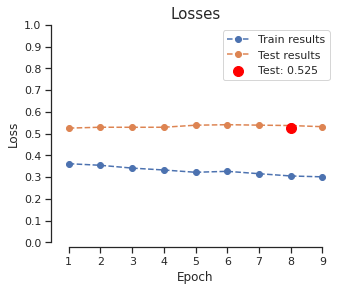

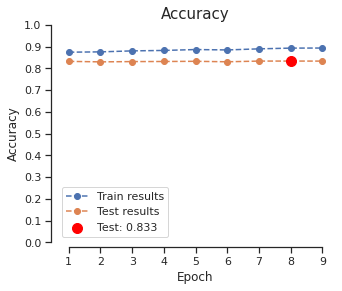

In [20]:
# cost function
loss_function = nn.CrossEntropyLoss()

# optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=model_config['lr'])
optimizer = torch.optim.Adam(model.parameters(), lr=model_config['lr'])

# LR Scheduler

# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
#     optimizer, T_0=5, T_mult=1, eta_min=1e-6, verbose=True)


# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#     optimizer, T_max=model_config['epochs'], verbose=True)

# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, patience=model_config['patience'], mode='max',
#     factor=1e-1, min_lr=1e-4, verbose=True)

# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=5 )

lr_scheduler = None

model_config["thld_accuracy"] = 0.0

# run_training_testing arguments
kwargs = {
    'model': model,
    'loss_function': loss_function,
    'optimizer': optimizer,
    'lr_scheduler': lr_scheduler,
    'map_classes': map_classes,
    'skip_classes': skip_classes,
    'device': device,
    'model_path': path_savedModels / f"{DATASET}_{PREFIX}.pth.tar",
    'trainloader': trainloader,
    'testloader': testloader,
    'config': model_config
}

# train
train_losses, val_losses, train_accs, val_accs, test_loss, test_acc, confusion_matrix_test, best_model_name = run_training_testing(**kwargs)

# Exporting last hidden layer data

In [15]:
# # create empty model
# model = model_(**model_setup)
# model.to(device)

# # load model
# # model_file_name = path_savedModels / 'MNIST_Elastic32-test_acc-0.971-test_loss-0.123.pth.tar'
# model_file_name = best_model_name
# load_checkpoint(model, model_file_name)

# model_file_name

In [16]:
# export last hidden layer for each data loader

# for loader, stage in [
#     (train_dataloader, 'train'),
#     (test_dataloader, 'test'),
# ]:
#     export_last_hidden_layer(loader, model, device, model.last_hidden_neurons,
#                           map_classes, path_lastHiddenLayer_raw, FILENAME_POSTFIX, stage)

# Confusion Matrix

In [17]:
# save_confusion_matrix(confusion_matrix_test, path_savedModels, FILENAME_POSTFIX, 'test')

In [18]:
# confusion_matrix_test_norm = normalize_confusion_matrix(confusion_matrix_test)
# fig, ax = plot_confusion_matrix( confusion_matrix_test_norm, map_classes=map_classes, fmt='.2f')